In [17]:
### Solve Heat Equation

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.testing as nptest
import scipy.sparse as sparse
import scipy.sparse.linalg as sparselinalg

In [18]:
# we are trying to solve problem for which u(x,y) = x**4*y**5-17*sin(xy) is a solution

In [19]:
def u(x,y): return x**4*y**5-17*np.sin(x*y)

In [20]:
#RHS
def f(x,y): return -(12*x**2*y**5+20*x**4*y**3+(x**2+y**2)*17*np.sin(x*y))

In [21]:
# our Omega is (0,1)x(0,1)
###generate RHS f, order nodes lexicographically
# determine pointwise values for u



In [22]:
#generate mesh, i.e. x_i,y_i (including the boundary)
# our n ranges from 2 to 8, i.e. if n=2, we have h_x=h_y=1/4
# if h=2**(-n), then there are 2**n+1 grid points in each direction

def meshvector(n):
    h=2**(-n)
    pts=2**n-1
    x=np.zeros(((2**n-1)**2,2))
    # print(len(x))
    for j in range(pts):
        for i in range(pts):
            x[pts*j+i,0]=(i+1)*2**(-n)
            x[pts*j+i,1]=(j+1)*2**(-n)
            # print((i,j))
            # print(x[n*j+i,:])
    return x

In [23]:
meshvector(2)

array([[ 0.25,  0.25],
       [ 0.5 ,  0.25],
       [ 0.75,  0.25],
       [ 0.25,  0.5 ],
       [ 0.5 ,  0.5 ],
       [ 0.75,  0.5 ],
       [ 0.25,  0.75],
       [ 0.5 ,  0.75],
       [ 0.75,  0.75]])

In [47]:
# determine values for f on mesh

def f_on_mesh(x,n):
    if(n==1):
        print("error, n too small")
    h=2**(-n)
    #print(h)
    #print(1/h**2)
    len_x=len(x)
    f_mesh = np.zeros(len_x)
    f_meshNoBound = np.zeros(len_x)
    for i in range(len_x):
        #print("index", i)
        f_mesh[i]=f(x[i,0],x[i,1])
        f_meshNoBound[i]=f_mesh[i]
        #print(f_mesh[i])
        if(i<2**n-1):
            f_mesh[i]+=u(x[i,0],x[i,1]-h)/h**2
            #print(1)
        if(i>=(2**n-1)*(2**n-2)):
            f_mesh[i]+=u(x[i,0],x[i,1]+h)/h**2
            #print(2)
        if((i % (2**n-1))==(2**n-2)):
            f_mesh[i]+=u(x[i,0]+h,x[i,1])/h**2
            #print(3)
            #print(u(x[i,0]+h,x[i,1])/h**2)
            #print(u(x[i,0]+h,x[i,1]))
        if((i % (2**n-1))==0):
            f_mesh[i]+=u(x[i,0]-h,x[i,1])/h**2
            # print(i % (2**n-1))
            #print(4)
            # print(x[i,:])
            # print(f_mesh[i])
    # print("f_mesh_no_bound: ", f_meshNoBound)
    return f_mesh        

In [37]:
x = meshvector(2)
f_on_mesh(x,2)

f_mesh_no_bound:  [ -0.13467918  -0.68479546  -2.08600378  -0.69553765  -2.35293365
  -6.06109243  -2.19147253  -6.29839712 -14.47089801]


array([ -1.34679175e-01,  -6.84795459e-01,  -6.93642557e+01,
        -6.95537646e-01,  -2.35293365e+00,  -1.35964839e+02,
        -6.94228494e+01,  -1.35702144e+02,  -3.76423008e+02])

In [28]:
# generating B part of A

def BpartA(n):
    h=1/2**n
    N=2**n-1
    data=[[-1/h**2]*(N)**2, [4/h**2]*(N)**2, [-1/h**2]*(N)**2]
    offsets = np.array([-1,0,1])
    b = sparse.dia_matrix((data, offsets),shape=(N,N)).toarray() 
    bmultiple = (b,)*(N)
    return sparse.block_diag(bmultiple).toarray()

In [29]:
BpartA(2)

array([[ 64., -16.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [-16.,  64., -16.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., -16.,  64.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  64., -16.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., -16.,  64., -16.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., -16.,  64.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  64., -16.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., -16.,  64., -16.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -16.,  64.]])

In [30]:
def CpartA(n):
    h=1/2**n
    N=2**n-1
    cdata=[[-1/h**2]*(N)**2,[-1/h**2]*(N)**2]
    offset=np.array([N,-N])
    return sparse.dia_matrix((cdata, offset),shape=((N)*(N),(N)*(N))).toarray()

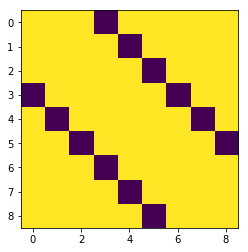

In [31]:
c=CpartA(2)
plt.imshow(c, interpolation='none')

In [49]:
def generateA(n):
    A=BpartA(n)+CpartA(n)
    #print(A.shape)
    return A

(9, 9)


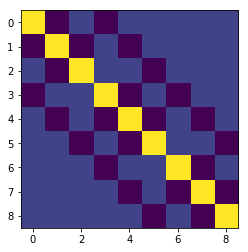

In [39]:
a=generateA(2)
plt.imshow(a, interpolation='none')

In [50]:
x=meshvector(2)
f_on_mesh(x,2)
generateA(2)
sparselinalg.spsolve(generateA(2), f_on_mesh(meshvector(2),2))
np.linalg.solve(generateA(2),f_on_mesh(meshvector(2),2))

C:\Users\Lisa\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


array([-1.06113632, -2.1179898 , -3.16662852, -2.11813802, -4.20139463,
       -6.2132583 , -3.16655004, -6.20913406, -8.9872076 ])

In [51]:
#compute the real solution at the grid points to check our results

n=3
x=meshvector(n)
u_real=np.zeros(len(x))
for i in range(len(x)):
    u_real=u(x[:,0],x[:,1])
u_approx=sparselinalg.spsolve(generateA(n), f_on_mesh(x,n))
print(u(0.5,0.5))
u_real-u_approx

-4.20391418233


C:\Users\Lisa\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


array([ -4.94251142e-05,  -1.00539379e-04,  -1.54884191e-04,
        -2.10831761e-04,  -2.58726041e-04,  -2.74629680e-04,
        -2.13154784e-04,  -9.70743097e-05,  -1.96686067e-04,
        -3.02440174e-04,  -4.11983683e-04,  -5.06986294e-04,
        -5.40312801e-04,  -4.21217035e-04,  -1.41605059e-04,
        -2.83998146e-04,  -4.34426679e-04,  -5.91915823e-04,
        -7.31734693e-04,  -7.85467047e-04,  -6.17419050e-04,
        -1.81827704e-04,  -3.56844217e-04,  -5.39543854e-04,
        -7.33980517e-04,  -9.13092227e-04,  -9.91365619e-04,
        -7.90220621e-04,  -2.14659987e-04,  -4.04843132e-04,
        -5.98829054e-04,  -8.10512110e-04,  -1.01663144e-03,
        -1.12317321e-03,  -9.16304498e-04,  -2.29155057e-04,
        -4.04933814e-04,  -5.77518127e-04,  -7.73540534e-04,
        -9.80533132e-04,  -1.11228962e-03,  -9.43641361e-04,
        -1.90957295e-04,  -3.05839688e-04,  -4.12951388e-04,
        -5.43273934e-04,  -6.97664826e-04,  -8.23271047e-04,
        -7.47173586e-04]